# Libs

In [1]:
import os
import time
import glob
import json
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Reshape, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Concatenate, Add, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, normalize

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

import lightgbm as lgb

from utils import *

In [222]:
X_nn = one_hot_encoding(X, categorical_features)
X_train, X_test, y_train, y_test = dataset_split(X, Y, 'random_transfer')

Train links: [1, 2, 4, 5, 7, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24] | Test links: [ 3  6  8 12 14 15]


# Weight Samples

## KDE

In [223]:
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
kde = kde.fit(X_test.values)
kde_weights = kde.score_samples(X_train.values)

## Logistic

In [224]:
X_data = np.concatenate((X_train.values, X_test.values),axis=0)
y_data = np.concatenate((np.zeros((X_train.shape[0],1)), np.ones((X_test.shape[0],1))),axis=0)

In [225]:
lr = LogisticRegression(penalty='l2',n_jobs=-1)
lr = lr.fit(X_data, y_data)
print("[Logistic] fit score: {:.3f}".format(lr.score(X_data, y_data)))
logit_weight = lr.predict_proba(X_train.values)[:,1]

[Logistic] fit score: 0.791


## LGB

In [226]:
X_data = pd.concat((X_train, X_test),axis=0)
y_data = np.concatenate((np.zeros((X_train.shape[0],1)), np.ones((X_test.shape[0],1))),axis=0)

In [227]:
params = {
    'objective':'binary',
    'boosting':'gbdt',
    'num_rounds':1000,
    'learning_rate':0.01,
    'max_depth':5,
    'num_leaves':20,
    'bagging_fraction':0.5,
    'bagging_freq':100,
    'verbose':2
}

train_data = lgb.Dataset(X_data, y_data.reshape(-1),categorical_feature=['weekday','interval',
                                                                         'holiday','peak'])
gbm = lgb.train(params, train_data)

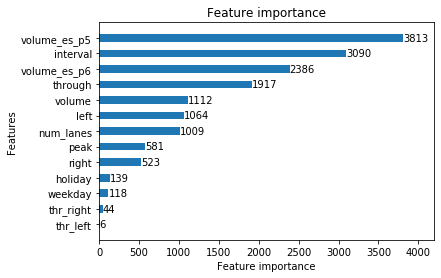

In [228]:
lgb.plot_importance(gbm, max_num_features=20,grid=False,height=0.5)

In [229]:
gbm_weights = gbm.predict(X_data)[:X_train.shape[0]]

## MLP

In [230]:
def build_mlp_clf(input_shape):
    x_in = Input(shape=(input_shape))

    def dense_block(h, units):
        h = Dense(units=units, use_bias=True,
                  activation=None,
                  kernel_initializer=he_normal(),
                  bias_initializer=constant(0.0))(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(0.2)(h)
        h = Dropout(rate=0.5)(h)
        return h

    h = dense_block(x_in, units=32)
    h = dense_block(h, units=16)
    h = Dense(units=1, use_bias=False,
              activation='sigmoid',
              kernel_initializer='normal',
              bias_initializer=constant(0.0))(h)

    mlp_clf = Model(inputs=x_in, outputs=h)
    mlp_clf.compile(loss='binary_crossentropy', optimizer=Adam(3e-4), metrics=['accuracy'])

    return mlp_clf

In [231]:
mlp_clf = build_mlp_clf(input_shape=X_data.shape[1])
hist = mlp_clf.fit(X_data, y_data, batch_size=256, epochs=10, shuffle=True)

Epoch 1/10
103680/103680 [==============================] - 2s 21us/sample - loss: 0.6500 - acc: 0.6525
Epoch 2/10
103680/103680 [==============================] - 2s 18us/sample - loss: 0.5832 - acc: 0.7304
Epoch 3/10
103680/103680 [==============================] - 2s 19us/sample - loss: 0.5652 - acc: 0.7375
Epoch 4/10
103680/103680 [==============================] - 2s 18us/sample - loss: 0.5544 - acc: 0.7388
Epoch 5/10
103680/103680 [==============================] - 2s 19us/sample - loss: 0.5455 - acc: 0.7418
Epoch 6/10
103680/103680 [==============================] - 2s 19us/sample - loss: 0.5396 - acc: 0.7413
Epoch 7/10
103680/103680 [==============================] - 2s 18us/sample - loss: 0.5316 - acc: 0.7394
Epoch 8/10
103680/103680 [==============================] - 2s 19us/sample - loss: 0.5247 - acc: 0.7381
Epoch 9/10
103680/103680 [==============================] - 2s 18us/sample - loss: 0.5191 - acc: 0.7379
Epoch 10/10
103680/103680 [==============================] - 2s 

In [232]:
mlp_weights = mlp_clf.predict(X_train.values)

# Train Regressor

In [234]:
trunc_kde_weights = -1 / kde_weights

In [235]:
train_data = lgb.Dataset(X_train, y_train, categorical_feature=['weekday','interval',
                                                                'holiday','peak'])
train_data.set_weight(gbm_weights)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

params = {
    'objective':'regression',
    'boosting':'gbdt',
    'metric':'mae',
    'num_rounds':2000,
    'learning_rate':0.01,
    'max_depth':8,
    'num_leaves':100,
    'feature_fraction':0.6,
    'bagging_fraction':0.6,
    'extra_trees':True,
    'bagging_freq':500,
    'verbose':2
}

gbm = lgb.train(params, train_data,valid_sets=[test_data])

[1]	valid_0's l1: 52.7076
[2]	valid_0's l1: 52.2879
[3]	valid_0's l1: 51.8707
[4]	valid_0's l1: 51.5186
[5]	valid_0's l1: 51.1763
[6]	valid_0's l1: 50.8395
[7]	valid_0's l1: 50.4361
[8]	valid_0's l1: 50.0494
[9]	valid_0's l1: 49.6592
[10]	valid_0's l1: 49.2765
[11]	valid_0's l1: 48.9673
[12]	valid_0's l1: 48.591
[13]	valid_0's l1: 48.2829
[14]	valid_0's l1: 47.9188
[15]	valid_0's l1: 47.553
[16]	valid_0's l1: 47.2159
[17]	valid_0's l1: 46.9216
[18]	valid_0's l1: 46.6327
[19]	valid_0's l1: 46.3408
[20]	valid_0's l1: 45.991
[21]	valid_0's l1: 45.6697
[22]	valid_0's l1: 45.3547
[23]	valid_0's l1: 45.0247
[24]	valid_0's l1: 44.6954
[25]	valid_0's l1: 44.3772
[26]	valid_0's l1: 44.2826
[27]	valid_0's l1: 44.0296
[28]	valid_0's l1: 43.7722
[29]	valid_0's l1: 43.4573
[30]	valid_0's l1: 43.1427
[31]	valid_0's l1: 42.9119
[32]	valid_0's l1: 42.6773
[33]	valid_0's l1: 42.3858
[34]	valid_0's l1: 42.1455
[35]	valid_0's l1: 41.9052
[36]	valid_0's l1: 41.6154
[37]	valid_0's l1: 41.3941
[38]	valid_0'

In [236]:
y_pred = gbm.predict(X_train)

print("[LightGBM] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_train),
    100 * mape(y_pred,y_train), 100 * mspe(y_pred, y_train)))

y_pred = gbm.predict(X_test)

print("[LightGBM] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_test),
    100 * mape(y_pred,y_test), 100 * mspe(y_pred, y_test)))

[LightGBM] mae: 14.73 | mape: 15.42% | mspe: 3.28%
[LightGBM] mae: 20.55 | mape: 27.49% | mspe: 12.54%


(0, 420)

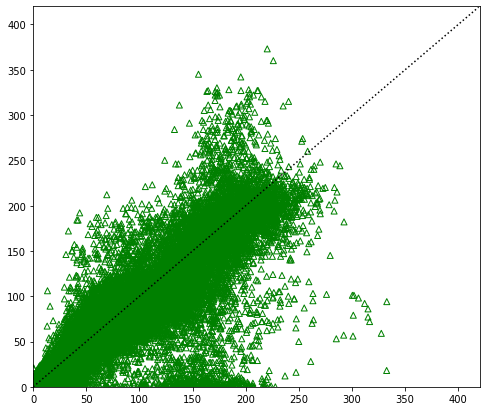

In [237]:
plt.figure(figsize=(8,7))
plt.scatter(y_pred,y_test,marker='^',c='',edgecolors='g')
plt.plot(np.arange(420),np.arange(420),'k:')
plt.xlim([0,420])
plt.ylim([0,420])